In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler

from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns

df = pd.read_csv("train.csv")

categ_df = df.select_dtypes(include=['object'])
numer_df =df.select_dtypes(exclude=['object'])

In [2]:
#Show features with at least some NaN values
null_counts = df.isnull().sum()
null_cols = []
##print("Percentage of null values in each column:\n")
for i in range(len(null_counts)):
    if null_counts[i] != 0:
        #print(null_counts.index[i], null_counts[i]/len(df))
        null_cols.append(null_counts.index[i])

In [3]:
#Features with too many NaN values, dropping them
#Also Id which has no correlation to houses, just a sample marker
df = df.drop(["Id","Alley","PoolQC","Fence","MiscFeature"],axis=1)

In [4]:
##df.info()

In [5]:
#Show features with at least some NaN values
null_counts = df.isnull().sum()
null_cols = []
#print("Number of null values in each column:\n")
for i in range(len(null_counts)):
    if null_counts[i] != 0:
        ##print(null_counts.index[i], null_counts[i])
        null_cols.append(null_counts.index[i])

In [6]:
#Columns that have the data description with an explanation for NaN values
##Basically indicates a lack of the feature is specified
valid_none_cols = ['BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2','GarageType',
                'GarageFinish','GarageQual','FireplaceQu','GarageCond']

##Filling in with value 'None' to indicate for machine learning later
df[valid_none_cols]= df[valid_none_cols].fillna('None')

In [7]:
#Organizing the other features with NaN values into numerical and categorical features
#"Invalid" simply means the data description didn't specify NaN values

invalid_none_cols = np.array(null_cols)
#Fill with feature names in null_cols that only are NOT already in valid_none_cols
invalid_none_cols = invalid_none_cols[[i not in valid_none_cols for i in invalid_none_cols]]

#Splitting
invalid_none_categ = invalid_none_cols[[i in categ_df for i in invalid_none_cols]]
invalid_none_numer = invalid_none_cols[[i in numer_df for i in invalid_none_cols]]

#print(invalid_none_categ)
##print(invalid_none_numer)
#fill missing values for each column (using its own most frequent value)
#object_columns_df[columns_with_lowNA] = object_columns_df[columns_with_lowNA].fillna(object_columns_df.mode().iloc[0])

### Dropping rows in MasVnrType and Electrical with NaN values

In [8]:
# According to data description file, the most columns uses 'NA' as 'No fireplace', 'No basement' and etc.
# However, MasVnrType/Electrical column contains 'NA' without any designation. Then it should be missing value.

bad_categ  = pd.concat([df['MasVnrType'],df['Electrical']],axis=1)
#Getting the particular rows in the df with NaN values
bad_rows = bad_categ[bad_categ.isna().any(axis=1)]
#Deleting these rows from the total df
df = df.drop(bad_rows.index)
#Categories without NaN descriptions should no longer have NaN values

In [9]:
##ADJUSTING NUMERICAL FEATURES
#For the most part these values can be assumed to indicate 0 when not filled with a number
##LotFrontage has many missing values, so all 0 wouldn't be great
#GarageYrBlt makes no sense with a value of 0. We'll change these two individually

#Adjusting LotFrontage by assuming the fill takes on the median value
#Perhaps this can be improved with comparisons to the LotArea feature?
df['LotFrontage'] = df['LotFrontage'].fillna(df['LotFrontage'].median())

#Adjusting GarageYrBlt based on the year the house was built

#plt.plot(df["GarageYrBlt"],df["YearBuilt"],"b.")
#plt.xticks(np.arange(min(df["GarageYrBlt"]),max(df["GarageYrBlt"]),20.0))
#plt.xlabel("Year Garage Built")
#plt.ylabel("Year Built")

#seems like the garage is built around the same year as the house or a bit later
#Again use the median value to fill in
df["GarageYrBlt"] = df["GarageYrBlt"].fillna(df['YearBuilt']-(df['GarageYrBlt']-df['YearBuilt']).median())

#Fill the rest of the null values to 0
for i in invalid_none_numer:
    df[i] = df[i].fillna(0)

## Removing Outliers based on plots

In [10]:
# GrLivArea and GarageArea columns have relatively large correlation with the SalePrice.
# Use scatterplots to detect the outliers.
def visualDetectionOutlier(train_df):
    sp = train_df['SalePrice']
    fig, axes = plt.subplots(nrows=2,ncols=1,figsize=(7,12))
    axes[0].scatter(x=train_df['GrLivArea'],y=sp, alpha=0.5)
    axes[0].set_title("GrLivArea vs SalePrice")
    axes[0].set_xlabel("sqft")
    axes[0].set_ylabel("Price")
    axes[1].scatter(x=train_df['GarageArea'],y=sp, alpha=0.5)
    axes[1].set_title("GarageArea vs SalePrice")
    axes[1].set_xlabel("sqft")
    axes[1].set_ylabel("Price")
    fig.tight_layout()
    plt.show()

In [11]:
# Before removing outliers.
##visualDetectionOutlier(df)

In [12]:
# [Plot 1: GrLivArea vs SalePrice] Bottom right two points look like outliers.
ol_plot1_bottomright = df.loc[(df['GrLivArea'] > 4000) & (df['SalePrice'] < 300000)]
# [Plot 2: GarageArea vs SalePrice] Bottom right four points look like outliers.
ol_plot2_bottomright = df.loc[((df['GarageArea'] > 1200) & (df['SalePrice'] < 300000))]
# [Plot 2: GarageArea vs SalePrice] Top middle two points look like outliers.
ol_plot2_topmiddle = df.loc[((df['GarageArea'] > 800) & (df['GarageArea'] < 1000)) &
                                  (df['SalePrice'] > 700000)]
# Remove the outliers.
df = df.drop(ol_plot1_bottomright.index.append(ol_plot2_bottomright.index).
                         append(ol_plot2_topmiddle.index))

In [13]:
# Check out the linearity again.
#visualDetectionOutlier(df)

# One Hot Encoding Categorical Data, Min-Max Scaling, Correlation Matrix

In [14]:
# According to the data description, these numeric columns are actually categorical columns.
num_to_cat_list = ['MSSubClass','OverallQual','OverallCond','YearBuilt', 
                             'YearBuilt','YearRemodAdd','MoSold','YrSold']
# Transform numeric data types into string data type.
df[num_to_cat_list] = df[num_to_cat_list].astype(str)

In [15]:
# The data type should be floating point because it indicates sqft.
df['MasVnrArea'] = df['MasVnrArea'].astype(np.float)

In [16]:
# Transform numerical features by scaling each feature to a given range.
categ_df = df.select_dtypes(include=['object'])
numer_df =df.select_dtypes(exclude=['object'])
#MIN MAX SCALER
scaler = MinMaxScaler()
df[numer_df.columns] = scaler.fit_transform(df[numer_df.columns])

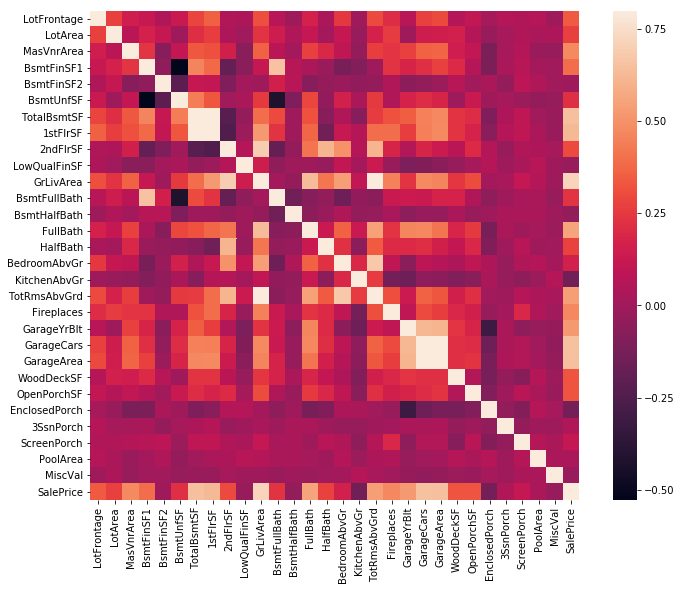

In [17]:
##This gets royally fucked by one hot encoding
corrmat = df.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

In [18]:
#Find out which parameters appear to have an appreciable linear relationship with SalePrice
#Arbitrary 0.5 correlation cutoff
print("List of parameters that have a good linear model fit to Sale Price")
# Correlation between SalePrice and other variables.
sorted_corrs = corrmat.loc['SalePrice'].abs().sort_values()[:-1]
for i in range(len(corrmat["SalePrice"])-1):
    #Likely to be a linear relationship
    if((corrmat["SalePrice"][i] > 0.5 or corrmat["SalePrice"][i] < -0.5)):
        print(corrmat.columns[i], corrmat["SalePrice"][i])

List of parameters that have a good linear model fit to Sale Price
TotalBsmtSF 0.6466812085464384
1stFlrSF 0.6268726701318776
GrLivArea 0.7216771976009548
FullBath 0.5606284641370041
TotRmsAbvGrd 0.5401086509685614
GarageYrBlt 0.5215241554070829
GarageCars 0.6532628671017016
GarageArea 0.6487457042566279


In [19]:
#Pandas One Hot Encoding
df = pd.get_dummies(df, columns=categ_df.columns, prefix=categ_df.columns, drop_first=True)

# Notes
- Use "df" for the cleaned data 
- Some features, like 'PoolArea', seem to mostly have all the same values. Perhaps worth dropping these as well if too many features for the model?
- Correlation matrix will help with linear regression models

In [20]:
df["PoolArea"].value_counts()

0.000000    1439
0.703252       1
0.780488       1
0.693767       1
0.878049       1
1.000000       1
Name: PoolArea, dtype: int64